# Librairies

In [2]:
import pandas as pd 
import geopandas as gpd
import matplotlib.pylab as plt
import numpy as np
import contextily as cx

# Data

In [16]:
# Include traffic data and geographical represent
df = gpd.read_file('raw/qlik_datos_imd_mobilitat_enero_2016-diciembre-2022_coord.geojson')

In [17]:
df.tipo_dato.value_counts()

tipo_dato
Entrada/Salida    1848
Anillo 2           840
Avda. Oeste        624
Anillo 0           504
Anillo 1           504
Ronda Sud          504
Ronda Nord         504
Name: count, dtype: int64

In [18]:
# Which years are included ?
df.ao.unique()

array(['2016', '2017', '2018', '2019', '2020', '2021', '2022', None],
      dtype=object)

In [19]:
df.imd.describe()

count       5328
unique      2583
top       60 354
freq          16
Name: imd, dtype: object

In [20]:
df.imd[0]

'79 117'

In [21]:
# Convert to integrals (remove the unnecessary spacce)
df.imd = df.imd.apply(lambda x : int(x.replace(' ', '')))

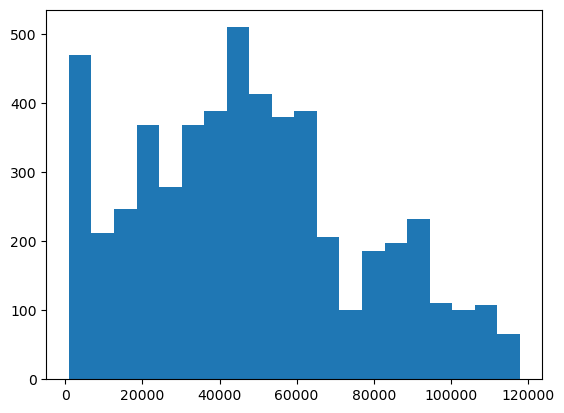

In [22]:
# Values are very high
plt.hist(df.imd, bins = 20)
plt.show()

In [23]:
# Remove values that we can't use
df.dropna(subset = ['ao', 'imd', 'geometry'], inplace=True)

In [24]:
df.rename(columns = {'imd' : 'AADT', 'punto_muestreo':'Street_names'}, inplace=True)

In [25]:
df[df.numero=='11'].latitud.unique()

array(['39.50020697'], dtype=object)

In [26]:
# There is one value per month, we shoulld aggregate it

df = df.groupby(['ao', 'numero']).agg(
    AAWT = ('AADT', 'mean'), #dias laborales
    geometry = ('geometry', lambda x : x.iloc[0]),
    raw_name = ('Street_names', lambda x : x.iloc[0])
).reset_index()

In [27]:
for year in df.ao.unique():
    print(year, df[df.ao==year].shape[0])

2016 32
2017 32
2018 32
2019 32
2020 32
2021 32
2022 30


In [28]:
df = gpd.GeoDataFrame(
    df,
    geometry = 'geometry',
    crs = 'epsg:4326'
)

(-0.42182691215, -0.33244035885, 39.435777846499995, 39.5032750235)

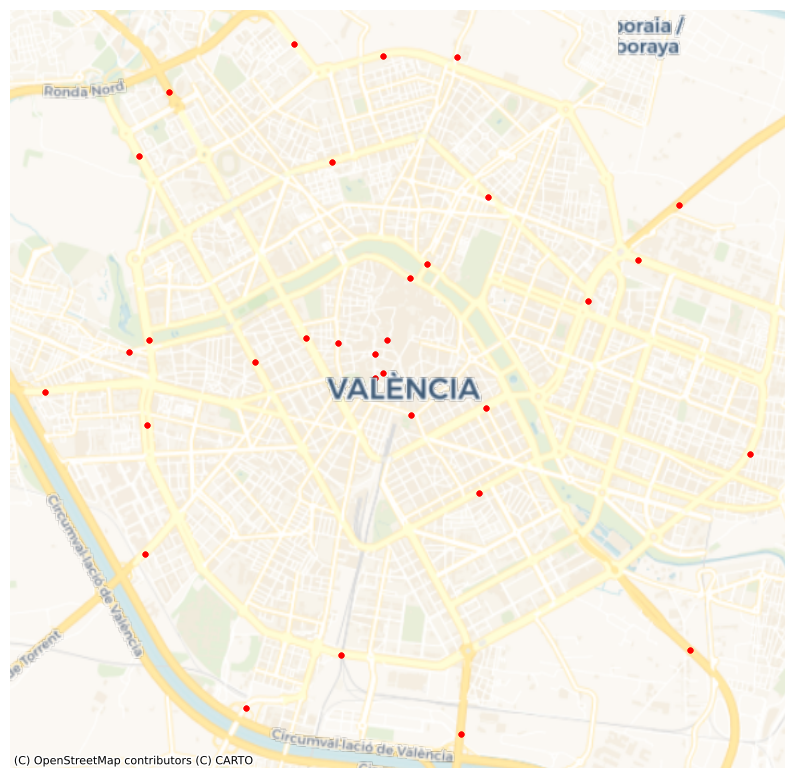

In [29]:
# Plot sensors
ax = df.plot(color = 'r', markersize = 10, alpha = .5, figsize = (10,10))
# Add context in backround
cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.VoyagerNoLabels)

cx.add_basemap(ax, crs = df.crs, source=cx.providers.CartoDB.VoyagerOnlyLabels)

# Remove lat lon
plt.axis('off')

In [30]:
df.AAWT.describe()

count       222.000000
mean      47766.061937
std       28296.765062
min        1777.000000
25%       26407.979167
50%       45945.333333
75%       64351.875000
max      112281.166667
Name: AAWT, dtype: float64

# Map matching with OSM

In [31]:
import sys
from pathlib import Path

# Add the ../assets directory to sys.path
sys.path.append(str(Path("../../assets").resolve()))

from map_matching_OSM import points_matching

In [32]:
gdf = df.drop_duplicates(subset = ['numero'])

In [33]:
gdf = points_matching(gdf)

City downloaded


 28%|██▊       | 9/32 [00:00<00:00, 85.96it/s]

Value Error - No roads found nearby current index


100%|██████████| 32/32 [00:00<00:00, 100.32it/s]

We failed to match 1 sensors
...on a total of 32 sensors


In [34]:
gdf[['raw_name', 'osm_name']].drop_duplicates().dropna()

,raw_name,osm_name
1,Avda. Maestro Rodrigo,Avinguda del Mestre Rodrigo
2,Avda. Hermanos Machado,Avinguda dels Germans Machado
3,Avda. Constitucion-Tavernes Blanques,Avinguda de la Constitució
4,Guillem de Castro,Carrer de Guillem de Castro
5,Xativa (plaza toros),Carrer de Xàtiva
6,Torres de Serrano,Carrer del Comte de Trénor
7,Fernando Catolico,Gran Via de Ferran el Catòlic
8,Marques de Turia,Gran Via del Marqués del Túria
9,Pont de Fusta,Carrer del Cronista Rivelles
10,Perez Galdos,Avinguda de Pérez Galdós


In [35]:
df = df.set_index('numero').join(
    gdf.set_index('numero')[['osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance', 'osmid']],
    how = 'left'
)

# Final saving

In [36]:
for year in df.ao.unique():
    df[df.ao == year][['AAWT', 'geometry', 'raw_name', 'osm_name', 'osm_type', 'osm_lanes', 'osm_oneway', 'osm_distance',]].to_file(
        f'treated/Valencia_AAWT_{year}.geojson', index = False
    )